In [3]:
import sklearn as sk
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import pickle

from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.palettes import plasma
from bokeh.plotting import figure
from bokeh.transform import transform
from sentence_transformers import SentenceTransformer


In [42]:
def plotting(embed, value, cluster):
    list_x = embed[:, 0]
    list_y = embed[:, 1]
    desc = value
    name = cluster

    source = ColumnDataSource(data=dict(x=list_x, y=list_y, desc=desc))
    hover = HoverTool(tooltips=[
        ('desc', '@desc'),
    ])
    mapper = LinearColorMapper(palette=plasma(256), low=min(list_y), high=max(list_y))

    p = figure(width=1000, height=1000, tools=[hover])
    p.circle('x', 'y', size=10, source=source)

    output_notebook()
    show(p)

In [38]:
data = pd.read_json('data/dataset-000.json')
df_title = data['title']
titles = []
for row in df_title:
    row = [row]
    titles = titles + row

model = SentenceTransformer('all-MiniLM-L6-v2')

#Words are encoded by calling model.encode()
embed = model.encode(titles)

plotting(embed, titles)

TypeError: plotting() missing 1 required positional argument: 'name'

# BIRCH

Estimated number of clusters: 1246
Estimated number of noise points: 0


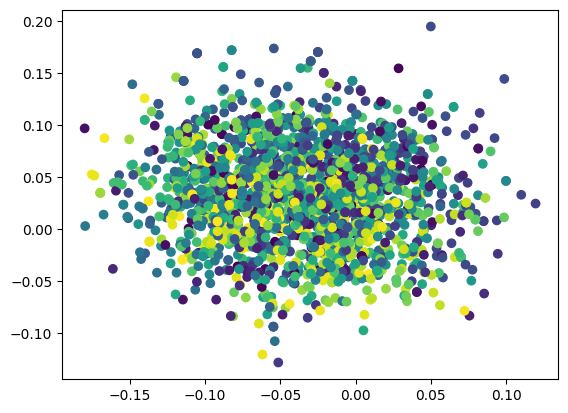

Loading BokehJS ...

In [43]:
brc = Birch(threshold=0.7, n_clusters=None)
brc.fit(embed)

brc_labels = brc.labels_

out = brc.predict(embed)


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(brc_labels)) - (1 if -1 in brc_labels else 0)
n_noise_ = list(brc_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

plt.scatter(embed[:,0], embed[:,1], c=out)
plt.show() 

#doesnt work
plotting(embed, titles)

In [16]:
test = pd.DataFrame(list(zip(titles, brc_labels)),
               columns =['Titles', 'Cluster_num'])
title_cluster_birch= test.sort_values(by=['Cluster_num'])
title_cluster_birch
title_cluster_birch.to_csv('clusters/titles/birch.csv') 

# DBSCAN

In [13]:
db = DBSCAN(eps=0.9, min_samples=10).fit(embed)
db_labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 6
Estimated number of noise points: 2024


In [17]:
test_db = pd.DataFrame(list(zip(titles, db_labels)),
               columns =['Titles', 'Cluster_num'])
title_cluster_db= test_db.sort_values(by=['Cluster_num'])
title_cluster_db
title_cluster_db.to_csv('clusters/titles/dbscan.csv') 

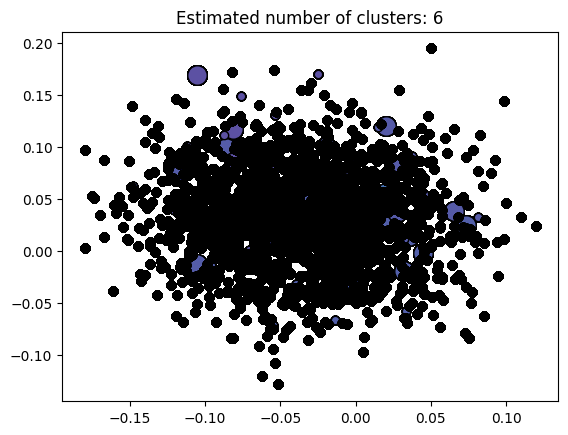

In [14]:
unique_labels = db.labels_
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = db_labels == k

    xy = embed[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = embed[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

# AffinityPropagation

Estimated number of clusters: 338
Estimated number of noise points: 0


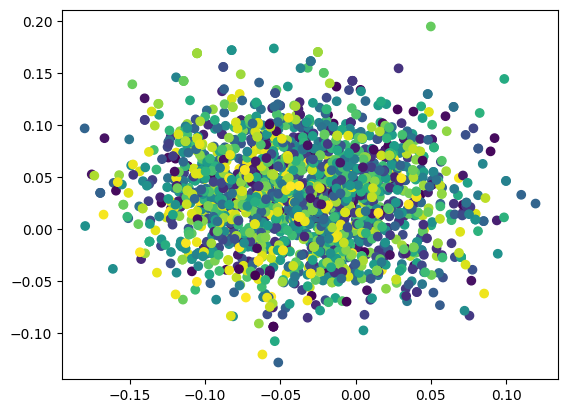

In [20]:
ap = AffinityPropagation(random_state=5).fit(embed)

ap_labels = ap.labels_

res = ap.fit_predict(embed)

ap.cluster_centers_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(ap_labels)) - (1 if -1 in ap_labels else 0)
n_noise_ = list(ap_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

plt.scatter(embed[:,0], embed[:,1], c=res)
plt.show() 

In [18]:
test = pd.DataFrame(list(zip(titles, ap_labels)),
               columns =['Titles', 'Cluster_num'])
title_cluster_AffinityPropagation= test.sort_values(by=['Cluster_num'])
title_cluster_AffinityPropagation
title_cluster_AffinityPropagation.to_csv('clusters/titles/AffinityPropagation.csv') 

# AgglomerativeClustering

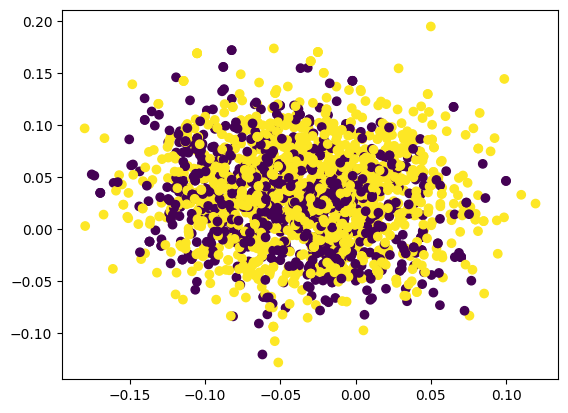

In [19]:
ac = AgglomerativeClustering().fit(embed)

ac_labels = ac.labels_

res = ac.fit_predict(embed)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(ac_labels)) - (1 if -1 in ac_labels else 0)
n_noise_ = list(ac_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

plt.scatter(embed[:,0], embed[:,1], c=res)
plt.show() 

In [21]:
test = pd.DataFrame(list(zip(titles, ac_labels)),
               columns =['Titles', 'Cluster_num'])
title_cluster_ac= test.sort_values(by=['Cluster_num'])
title_cluster_ac
title_cluster_ac.to_csv('clusters/titles/AgglomerativeClustering.csv') 

# MeanShift

In [18]:
# The following bandwidth can be automatically detected using
bandwidth = sk.cluster.estimate_bandwidth(embed, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(embed)
ms_labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(ms_labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 1


Estimated number of clusters: 134
Estimated number of noise points: 0


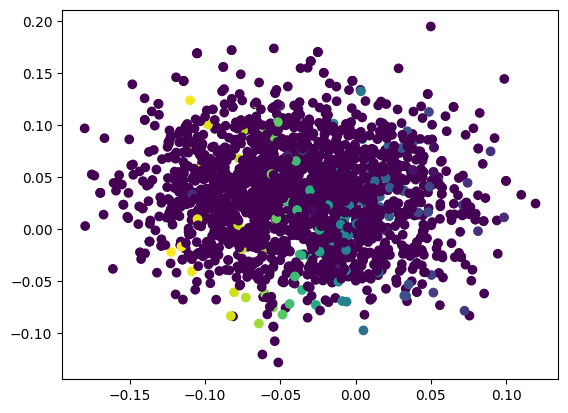

In [26]:
ms  = MeanShift(bandwidth=1).fit(embed)

ms_labels = ms.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(ms_labels)) - (1 if -1 in ms_labels else 0)
n_noise_ = list(ms_labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

res = ms.fit_predict(embed)

plt.scatter(embed[:,0], embed[:,1], c=res)
plt.show() 


In [27]:
test = pd.DataFrame(list(zip(titles, ms_labels)),
               columns =['Titles', 'Cluster_num'])
title_cluster_ms= test.sort_values(by=['Cluster_num'])
title_cluster_ms
title_cluster_ms.to_csv('clusters/titles/MeanShift.csv') 

# Compare algorithms with one function

In [ ]:
def cluster(model, embed):
    md = model.fit(embed)